# Using Parallelism with Machine Learning: The Housing Prices Competition 

## Description of the competition

- The Housing Prices Competition train_dataset consists of various features of residential homes in Ames, Iowa, including both quantitative and categorical variables like the size of the property, the number of rooms, year built, and neighborhood quality.
- It includes a set of 79 explanatory variables describing almost every aspect of the houses, allowing for in-depth analysis.
- *The primary goal* of the competition is to predict **the final price of each home**, in this lab we will use *RandomForests*.
- The models are evaluated on Root Mean Squared Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price, encouraging precise predictions over a range of housing prices.

### File descriptions
- *train.csv*: the training set used to train the model.
- *test.csv*: the test set used to compute the performance of the model.
- *train_data_description.txt*: full description of each column.
### Useful train_data fields

Here's a brief version of what you'll find in the train_data description file.

- *SalePrice*: the property's sale price in dollars. This is the target variable that you're trying to predict.
- *MSSubClass*: The building class
- *MSZoning*: The general zoning classification

Teh train_dataset is acessible here: https://www.kaggle.com/code/dansbecker/random-forests/tutorial

## Read and prepare the train_data
*If you're curious about this the professor can explain it for you*.

In [20]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load the train_dataset
file_path = '../data/housing_prices_data/train.csv'
train_data = pd.read_csv(file_path, index_col="Id")

# Columns to be deleted
columns_to_delete = ['MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

# Delete the specified columns
train_data_cleaned = train_data.drop(columns=columns_to_delete, axis=1)

# Define the input features (X) and the output (y)
X = train_data_cleaned.drop('SalePrice', axis=1)
y = train_data_cleaned['SalePrice']

# Identify the categorical columns in X
categorical_columns = X.select_dtypes(include=['object']).columns

# Initialize a LabelEncoder for each categorical column
label_encoders = {column: LabelEncoder() for column in categorical_columns}

# Apply Label Encoding to each categorical column
for column in categorical_columns:
    X[column] = label_encoders[column].fit_transform(X[column])


## Split the Data into training and test

In [21]:
from sklearn.model_selection import train_test_split

# Split the first dataset (X, y) into train and test sets with a 70% - 30% split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=42)

# Fill NaN values in X_train and X_val with the median of the respective columns
X_train_filled = X_train.fillna(X_train.median())
X_val_filled = X_val.fillna(X_val.median())

(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

((1022, 70), (438, 70), (1022,), (438,))

## First RandomForest Model
This is the code for a simple trial.

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt


# Create a Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Train the model on the training data
rf_model.fit(X_train_filled, y_train)

# Make predictions on the validation data
y_val_pred_filled = rf_model.predict(X_val_filled)

# Calculate the RMSE on the validation data
rmse_filled = sqrt(mean_squared_error(y_val, y_val_pred_filled))

# Calculate MAPE (mean absolute percentage error)
mape = mean_absolute_percentage_error(y_val, y_val_pred_filled) * 100

# Print the RMSE and MAPE
print(f"RMSE: {rmse_filled}, MAPE: {mape}%")

RMSE: 26057.941851126383, MAPE: 9.868196740754167%


### Parameters of Random Forest Model
The three most important parameters that typically have the most impact on the performance of a Random Forest model are:

- *n_estimators*: This parameter specifies the number of trees in the forest. Generally, a higher number of trees increases the performance and makes the predictions more stable, but it also makes the computation slower. Selecting the right number of trees requires balancing between performance and computational efficiency.

- *max_features*: This parameter defines the maximum number of features that are allowed to try in an individual tree. There are several options available for this parameter:

    - *sqrt*: This is commonly used and means that the maximum number of features used at each split is the square root of the total number of features.
    - *log2*: This is another typical option, meaning the log base 2 of the feature count is used.
    - *A specific integer or float*: You can specify an exact number or a proportion of the total.

- *max_depth*: This parameter specifies the maximum depth of each tree. Deeper trees can model more complex patterns, but they also risk overfitting. Limiting the depth of trees can improve the model's generalization and reduce overfitting. It's often useful to set this parameter to a finite value, especially when dealing with a large number of features.

## Finding the best parameters sequentially

In [10]:
import time
from sklearn.metrics import mean_absolute_percentage_error

start_time = time.time()

# Define the parameter ranges
n_estimators_range = [10, 25, 50, 100, 200, 300, 400]
max_features_range = ['sqrt', 'log2', None]  # None means using all features
max_depth_range = [1, 2, 5, 10, 20, None]  # None means no limit

# Initialize variables to store the best model and its RMSE and parameters
best_rmse = float('inf')
best_mape = float('inf')
best_model = None
best_parameters = {}

# Loop over all possible combinations of parameters
for n_estimators in n_estimators_range:
    for max_features in max_features_range:
        for max_depth in max_depth_range:
            # Create and train the Random Forest model
            rf_model = RandomForestRegressor(
                n_estimators=n_estimators,
                max_features=max_features,
                max_depth=max_depth,
                random_state=42
            )
            rf_model.fit(X_train_filled, y_train)
            
            # Make predictions and compute RMSE
            y_val_pred = rf_model.predict(X_val_filled)
            rmse = sqrt(mean_squared_error(y_val, y_val_pred))
            # Compute MAPE
            mape = mean_absolute_percentage_error(y_val, y_val_pred) * 100
            print(f"The parameters: {n_estimators}, {max_features}, {max_depth}. RMSE: {rmse}, MAPE: {mape}%")
            # If the model is better than the current best, update the best model and its parameters
            if rmse < best_rmse:
                best_rmse = rmse
                best_mape = mape
                best_model = rf_model
                best_parameters = {
                    'n_estimators': n_estimators,
                    'max_features': max_features,
                    'max_depth': max_depth
                }
print(f"The best parameters {best_parameters} for RMSE = {best_rmse}, MAPE: {mape}%")
end_time = time.time()
sequential_time = start_time - end_time
print(f"The sequential execution time is {end_time - start_time}")

The parameters: 10, sqrt, 1. RMSE: 62936.129262244904, MAPE: 26.860734529882123%
The parameters: 10, sqrt, 2. RMSE: 51806.105176310826, MAPE: 20.52147680573829%
The parameters: 10, sqrt, 5. RMSE: 34018.6946431472, MAPE: 13.846204059816515%
The parameters: 10, sqrt, 10. RMSE: 30158.362616471855, MAPE: 11.1847373574493%
The parameters: 10, sqrt, 20. RMSE: 30593.76147467334, MAPE: 11.148658516638926%
The parameters: 10, sqrt, None. RMSE: 28608.440009540453, MAPE: 11.124252485645316%
The parameters: 10, log2, 1. RMSE: 64442.107292878405, MAPE: 27.58882909655716%
The parameters: 10, log2, 2. RMSE: 51396.530250771764, MAPE: 21.498982900746558%
The parameters: 10, log2, 5. RMSE: 34956.394381827566, MAPE: 13.945831547616713%
The parameters: 10, log2, 10. RMSE: 30136.927641357106, MAPE: 11.160840785213171%
The parameters: 10, log2, 20. RMSE: 30841.310557247474, MAPE: 11.240205002153882%
The parameters: 10, log2, None. RMSE: 29000.351214559596, MAPE: 10.98098439114081%
The parameters: 10, None, 

# Trying parallelism 

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def data_preprocessing():
    # Load the train_dataset
    file_path = '../data/housing_prices_data/train.csv'
    train_data = pd.read_csv(file_path, index_col="Id")

    # Columns to be deleted
    columns_to_delete = ['MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

    # Delete the specified columns
    train_data_cleaned = train_data.drop(columns=columns_to_delete, axis=1)

    # Define the input features (X) and the output (y)
    X = train_data_cleaned.drop('SalePrice', axis=1)
    y = train_data_cleaned['SalePrice']

    # Identify the categorical columns in X
    categorical_columns = X.select_dtypes(include=['object']).columns

    # Initialize a LabelEncoder for each categorical column
    label_encoders = {column: LabelEncoder() for column in categorical_columns}

    # Apply Label Encoding to each categorical column
    for column in categorical_columns:
        X[column] = label_encoders[column].fit_transform(X[column])

    # Split the first dataset (X, y) into train and test sets with a 70% - 30% split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=42)

    # Fill NaN values in X_train and X_val with the median of the respective columns
    X_train_filled = X_train.fillna(X_train.median())
    X_val_filled = X_val.fillna(X_val.median())
    
    return (X_train_filled, X_val_filled, y_train, y_val)
    

In [12]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

def train_model(n_estimators, max_features, max_depth, shared_data):
    global X_train_filled, y_train, X_val_filled, y_val
    # Create and train the Random Forest model
    rf_model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_features=max_features,
        max_depth=max_depth,
        random_state=42
    )
    rf_model.fit(X_train_filled, y_train)
    
    # Make predictions and compute RMSE
    y_val_pred = rf_model.predict(X_val_filled)
    rmse = sqrt(mean_squared_error(y_val, y_val_pred))
    # Compute MAPE
    mape = mean_absolute_percentage_error(y_val, y_val_pred) * 100
    print(f"The parameters: {n_estimators}, {max_features}, {max_depth}. RMSE: {rmse}, MAPE: {mape}%")
    # If the model is better than the current best, update the best model and its parameters
    if rmse < shared_data['best_rmse']:
        shared_data['best_rmse'] = rmse
        shared_data['best_mape'] = mape
        shared_data['best_model'] = rf_model
        shared_data['best_parameters'] = {
            'n_estimators': n_estimators,
            'max_features': max_features,
            'max_depth': max_depth
        }

## sequential

In [13]:
import time

def sequential_parameter_finder(n_estimators_range, max_features_range, max_depth_range):
    print("*"*20, "Starting Sequential Parameter Finder", "*"*20)
    parallel_time = time.time()
    
    # Initialize variables to store the best model and its RMSE and parameters
    shared_data = dict()
    shared_data['best_rmse'] = float('inf')
    shared_data['best_mape'] = float('inf')
    shared_data['best_model'] = None
    shared_data['best_parameters'] = {}

    # Loop over all possible combinations of parameters
    for n_estimators in n_estimators_range:
        for max_features in max_features_range:
            for max_depth in max_depth_range:
                train_model(n_estimators, max_features, max_depth, shared_data)

    print(f"The best parameters {shared_data['best_parameters']} for RMSE = {shared_data['best_rmse']}, MAPE: {shared_data['best_mape']}%")
    
    parallel_time = time.time() - parallel_time 
    print(f"The sequential execution time is {parallel_time}", "\n"*5)
    return parallel_time

## threads

In [14]:
import time
import threading

def threading_parameter_finder(n_estimators_range, max_features_range, max_depth_range):
    print("*"*20, "Starting Threading Parameter Finder", "*"*20)
    parallel_time = time.time()
    # Initialize variables to store the best model and its RMSE and parameters
    shared_data = dict()
    shared_data['best_rmse'] = float('inf')
    shared_data['best_mape'] = float('inf')
    shared_data['best_model'] = None
    shared_data['best_parameters'] = {}

    threads = []
    # Loop over all possible combinations of parameters
    for n_estimators in n_estimators_range:
        for max_features in max_features_range:
            for max_depth in max_depth_range:
                thread = threading.Thread(target=train_model, args=(n_estimators, max_features, max_depth, shared_data))
                threads.append(thread)
                thread.start()

    for thread in threads:
        thread.join()

    print(f"The best parameters {shared_data['best_parameters']} for RMSE = {shared_data['best_rmse']}, MAPE: {shared_data['best_mape']}%")

    parallel_time = time.time() - parallel_time 
    print(f"The threading execution time is {parallel_time}", "\n"*5)
    return parallel_time

## multiprocessing

In [15]:
import time
import multiprocessing

def multiprocessing_parameter_finder(n_estimators_range, max_features_range, max_depth_range):
    print("*"*20, "Starting Multiprocessing Parameter Finder", "*"*20)

    parallel_time = time.time()

    # Initialize variables to store the best model and its RMSE and parameters
    shared_data = multiprocessing.Manager().dict()
    shared_data['best_rmse'] = float('inf')
    shared_data['best_mape'] = float('inf')
    shared_data['best_model'] = None
    shared_data['best_parameters'] = {}

    processes = []
    # Loop over all possible combinations of parameters
    for n_estimators in n_estimators_range:
        for max_features in max_features_range:
            for max_depth in max_depth_range:
                process = multiprocessing.Process(target=train_model, args=(n_estimators, max_features, max_depth, shared_data))
                processes.append(process)
                process.start()

    for process in processes:
        process.join()

    print(f"The best parameters {shared_data['best_parameters']} for RMSE = {shared_data['best_rmse']}, MAPE: {shared_data['best_mape']}%")

    parallel_time = time.time() - parallel_time 
    print(f"The multiprocessing execution time is {parallel_time}", "\n"*5)
    return parallel_time

## Measuring performance

In [16]:
total_time = time.time()

# Preprocess the data and split
X_train_filled, X_val_filled, y_train, y_val = data_preprocessing()

# Define the parameter ranges
n_estimators_range = [10, 25, 50, 100, 200, 300, 400]
max_features_range = ['sqrt', 'log2', None]  # None means using all features
max_depth_range = [1, 2, 5, 10, 20, None]  # None means no limit

# Run sequential, threading, and multiprocessing parameter finder
sequential_time = sequential_parameter_finder(n_estimators_range, max_features_range, max_depth_range)
threading_time = threading_parameter_finder(n_estimators_range, max_features_range, max_depth_range)
multiprocessing_time = multiprocessing_parameter_finder(n_estimators_range, max_features_range, max_depth_range)

total_time =  time.time() - total_time
print(f"The total execution time is {total_time}")

******************** Starting Sequential Parameter Finder ********************
The parameters: 10, sqrt, 1. RMSE: 62936.129262244904, MAPE: 26.860734529882123%
The parameters: 10, sqrt, 2. RMSE: 51806.105176310826, MAPE: 20.52147680573829%
The parameters: 10, sqrt, 5. RMSE: 34018.6946431472, MAPE: 13.846204059816515%
The parameters: 10, sqrt, 10. RMSE: 30158.362616471855, MAPE: 11.1847373574493%
The parameters: 10, sqrt, 20. RMSE: 30593.76147467334, MAPE: 11.148658516638926%
The parameters: 10, sqrt, None. RMSE: 28608.440009540453, MAPE: 11.124252485645316%
The parameters: 10, log2, 1. RMSE: 64442.107292878405, MAPE: 27.58882909655716%
The parameters: 10, log2, 2. RMSE: 51396.530250771764, MAPE: 21.498982900746558%
The parameters: 10, log2, 5. RMSE: 34956.394381827566, MAPE: 13.945831547616713%
The parameters: 10, log2, 10. RMSE: 30136.927641357106, MAPE: 11.160840785213171%
The parameters: 10, log2, 20. RMSE: 30841.310557247474, MAPE: 11.240205002153882%
The parameters: 10, log2, None

# Getting better results

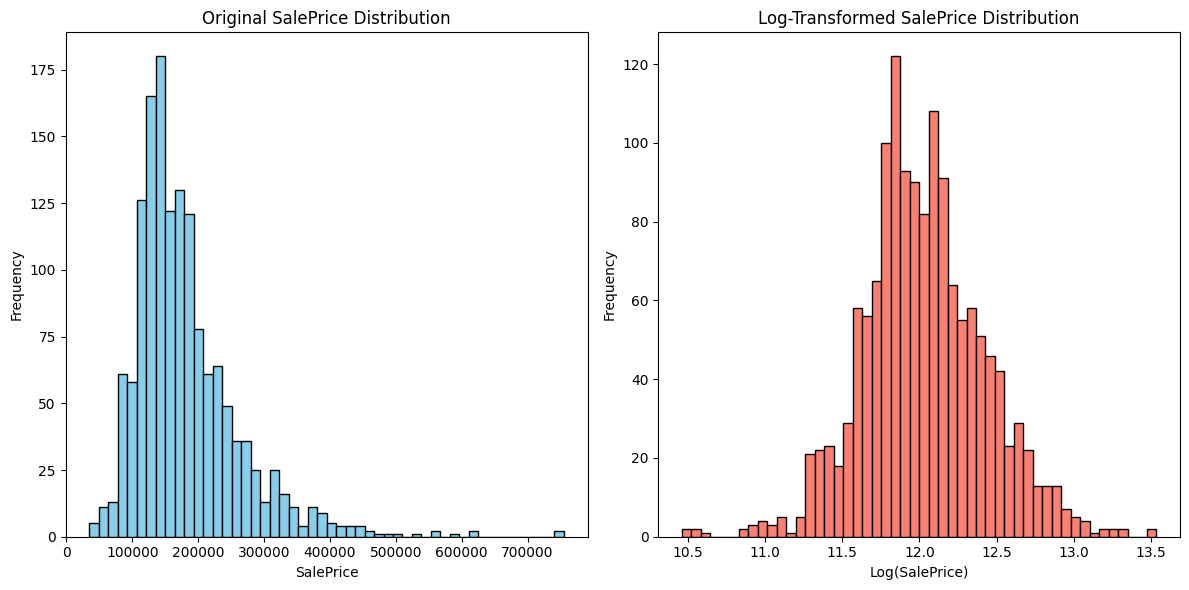

In [8]:
import matplotlib.pyplot as plt
import numpy as np

y_log = np.log1p(y)

plt.figure(figsize=(12, 6))

# Plot original distribution
plt.subplot(1, 2, 1)
plt.hist(y, bins=50, color='skyblue', edgecolor='black')
plt.title('Original SalePrice Distribution')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')

# Plot log-transformed distribution
plt.subplot(1, 2, 2)
plt.hist(y_log, bins=50, color='salmon', edgecolor='black')
plt.title('Log-Transformed SalePrice Distribution')
plt.xlabel('Log(SalePrice)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

# Load the train dataset
file_path = '../data/housing_prices_data/train.csv'
train_data = pd.read_csv(file_path, index_col="Id")

# Columns to be deleted
columns_to_delete = ['MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

# Delete the specified columns
train_data_cleaned = train_data.drop(columns=columns_to_delete, axis=1)

# Define the input features (X) and the output (y)
X = train_data_cleaned.drop('SalePrice', axis=1)
y = train_data_cleaned['SalePrice']

# Feature engineering: Apply log transformation to target variable
y = np.log1p(y)

# Identify the categorical columns in X
categorical_columns = X.select_dtypes(include=['object']).columns

# Initialize a LabelEncoder for each categorical column
label_encoders = {column: LabelEncoder() for column in categorical_columns}

# Apply Label Encoding to each categorical column
for column in categorical_columns:
    X[column] = label_encoders[column].fit_transform(X[column])

print(f"Before Outlier Removal: {X.shape[0]} rows")

# Calculate IQR for target variable (y)
Q1_y = y.quantile(0.25)
Q3_y = y.quantile(0.75)
IQR_y = Q3_y - Q1_y

# Identify outliers in y and remove them
y_cleaned = y[(y >= (Q1_y - 1.5 * IQR_y)) & (y <= (Q3_y + 1.5 * IQR_y))]W

# Apply the same outlier removal to X
X_cleaned = X.loc[y_cleaned.index]

# Print the number of rows after outlier removal
print(f"After Outlier Removal: {y_cleaned.shape[0]} rows")

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X_cleaned, y_cleaned, test_size=0.30, random_state=42)

# Fill NaN values in X_train and X_val with the median of the respective columns
X_train_filled = X_train.fillna(X_train.median())
X_val_filled = X_val.fillna(X_val.median())

# Create a Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Cross-validation score (5-fold cross-validation)
cv_score = cross_val_score(rf_model, X_train_filled, y_train, cv=5, scoring='neg_mean_squared_error')

# Print the cross-validation scores
print(f"Cross-Validation Scores: {cv_score}")
print(f"Mean CV Score: {cv_score.mean()}")

# Train the model on the training data
rf_model.fit(X_train_filled, y_train)

# Make predictions on the validation data
y_val_pred_filled = rf_model.predict(X_val_filled)

# Calculate RMSE
rmse_filled = sqrt(mean_squared_error(y_val, y_val_pred_filled))

# Calculate MAPE (mean absolute percentage error) on original scale
mape = np.mean(np.abs((np.expm1(y_val) - np.expm1(y_val_pred_filled)) / np.expm1(y_val))) * 100

# Print the RMSE, MAPE, and Cross-Validation Score
print(f"RMSE: {rmse_filled}")
print(f"MAPE: {mape}%")


Before Outlier Removal: 1460 rows
After Outlier Removal: 1432 rows
Cross-Validation Scores: [-0.01714227 -0.0179534  -0.02560619 -0.01922953 -0.0177627 ]
Mean CV Score: -0.019538819086753798
RMSE: 0.12786756064088864
MAPE: 9.060036024442187%
